In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import pickle
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.models import RNNModel

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

c:\Users\sakif\miniconda3\envs\darts\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\sakif\miniconda3\envs\darts\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\sakif\miniconda3\envs\darts\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = "\_LSTM_model.pth.tar"   # file name to save the model under

EPOCHS = 100
INLEN = 32          # input size
FEAT = 32           # d_model = number of expected features in the inputs, up to 512    
HEADS = 4           # default 8
ENCODE = 4          # encoder layers
DECODE = 4          # decoder layers
DIM_FF = 128        # dimensions of the feedforward network, default 2048
BATCH = 32          # batch size
ACTF = "relu"       # activation function, relu (default) or gelu
SCHLEARN = None     # a PyTorch learning rate scheduler; None = constant rate
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
DROPOUT = 0.1       # dropout rate
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath = os.path.abspath(os.getcwd()) + SAVE     # path and file name to save the model

# Wrangling and Exploration

In [3]:
# load
df0 = pd.read_csv("energy_data.csv", header=0, parse_dates=["DateTime"])
dfw0 = pd.read_csv("weather_dataset.csv", header=0, parse_dates=["DateTime"])

In [4]:
df0.iloc[[0, -1]]

DateTime  Tripura  Eastern Grid Total  Western Grid Total  \
0     2018-01-01 00:00:00       90            4,328.00            1,345.00   
43823 2022-12-31 23:00:00      100            5,016.00            3,093.00   

       Total (MW)  Gas (Public)  HVDC  Gas (Private)  Oil (Private)  Coal  \
0        5,673.00      3,015.00   460           1715         292.00   169   
43823    8,109.00      3,164.00   919           1589       1,375.00   888   

       Hydro  Oil (Public)  Solar  Shortage  
0      79.00           200   0.00      0.00  
43823  46.00            28   0.00      0.00

In [5]:
dfw0.iloc[[0, -1]]

DateTime  maxtempC  mintempC  DewPointC  FeelsLikeC  \
0      2018-01-01 00:00:00        28        20         13          25   
394415 2022-12-31 23:00:00        27        11          6          14   

        HeatIndexC  cloudcover  humidity  pressure  tempC  winddirDegree  \
0               25          15        54      1013     22            259   
394415          14           2        59      1018     14            102   

        windspeedKmph     Area  
0                   3  BARISAL  
394415              4   SYLHET

In [6]:
# backup of original sources
df1 = df0.copy()
dfw1 = dfw0.copy()

## Preparing the energy dataframe dfw1

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DateTime            43824 non-null  datetime64[ns]
 1   Tripura             43824 non-null  int64         
 2   Eastern Grid Total  43824 non-null  float64       
 3   Western Grid Total  43824 non-null  float64       
 4   Total (MW)          43824 non-null  float64       
 5   Gas (Public)        43824 non-null  float64       
 6   HVDC                43824 non-null  int64         
 7   Gas (Private)       43824 non-null  int64         
 8   Oil (Private)       43824 non-null  float64       
 9   Coal                43824 non-null  int64         
 10  Hydro               43824 non-null  float64       
 11  Oil (Public)        43824 non-null  int64         
 12  Solar               43824 non-null  float64       
 13  Shortage            43824 non-null  float64   

In [8]:
# datetime
df1["DateTime"] = pd.to_datetime(df1["DateTime"], utc=True, infer_datetime_format=True)


# any duplicate time periods?
print("count of duplicates:",df1.duplicated(subset=["DateTime"], keep="first").sum())


df1.set_index("DateTime", inplace=True)


# any non-numeric types?
print("non-numeric columns:",list(df1.dtypes[df1.dtypes == "object"].index))


# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")
gaps(df1)  


count of duplicates: 0
non-numeric columns: []
no missing values



In [9]:
# drop the NaN and zero columns, and also the 'forecast' columns
df1 = df1.drop('Shortage', axis=1)

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2018-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tripura             43824 non-null  int64  
 1   Eastern Grid Total  43824 non-null  float64
 2   Western Grid Total  43824 non-null  float64
 3   Total (MW)          43824 non-null  float64
 4   Gas (Public)        43824 non-null  float64
 5   HVDC                43824 non-null  int64  
 6   Gas (Private)       43824 non-null  int64  
 7   Oil (Private)       43824 non-null  float64
 8   Coal                43824 non-null  int64  
 9   Hydro               43824 non-null  float64
 10  Oil (Public)        43824 non-null  int64  
 11  Solar               43824 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 4.3 MB


In [11]:
# rename columns
colnames_old = df1.columns
colnames_new = ["gen_tripura", "gen_east_grid", "gen_west_grid", "load_actual", \
                "gen_gas_pub", "gen_HVDC", "gen_gas_pri", "gen_oil_pri", \
                "gen_coal", "gen_hydro", "gen_oil_pub", "gen_solar"]
dict_cols = dict(zip(colnames_old, colnames_new))
df1.rename(columns=dict_cols, inplace=True)
print(df1.info())
df1.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2018-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gen_tripura    43824 non-null  int64  
 1   gen_east_grid  43824 non-null  float64
 2   gen_west_grid  43824 non-null  float64
 3   load_actual    43824 non-null  float64
 4   gen_gas_pub    43824 non-null  float64
 5   gen_HVDC       43824 non-null  int64  
 6   gen_gas_pri    43824 non-null  int64  
 7   gen_oil_pri    43824 non-null  float64
 8   gen_coal       43824 non-null  int64  
 9   gen_hydro      43824 non-null  float64
 10  gen_oil_pub    43824 non-null  int64  
 11  gen_solar      43824 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 4.3 MB
None


gen_tripura  gen_east_grid  gen_west_grid  load_actual  gen_gas_pub  \
count    43,824.00      43,824.00      43,824.00    43,824.00    43,824.00   
mean        113.10       6,070.73       2,671.05     8,741.86     3,651.81   
std          31.18       1,317.31         837.45     2,043.45       627.59   
min           0.00         168.00           1.00     1,774.00         0.00   
25%          90.00       5,033.00       2,032.62     7,157.00     3,208.00   
50%         112.00       6,051.75       2,637.85     8,658.80     3,703.00   
75%         136.00       7,051.00       3,225.00    10,263.00     4,124.00   
max         198.00       9,981.00       5,273.00    14,782.00     5,321.00   

       gen_HVDC  gen_gas_pri  gen_oil_pri  gen_coal  gen_hydro  gen_oil_pub  \
count 43,824.00    43,824.00    43,824.00 43,824.00  43,824.00    43,824.00   
mean     679.25     1,696.54     1,752.19    479.18      89.22       275.53   
std      227.16       328.76     1,168.44    297.70      49.33       331.30   
min        0.00        85.00         0.00      0.00       0.00         0.00   
25%      487.00     1,466.00       772.00    235.00      46.00        10.00   
50%      717.00     1,717.00     1,631.00    449.00      76.00       128.00   
75%      902.00     1,941.00     2,579.25    650.00     123.00       462.00   
max      978.00     2,839.00     5,460.00  1,514.00     271.00     1,783.00   

       gen_solar  
count  43,824.00  
mean       18.37  
std        40.32  
min         0.00  
25%         0.00  
50%         0.00  
75%        16.00  
max       316.00

In [12]:
df1 = df1.reset_index()


In [13]:
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Define a custom holiday calendar for Bangladesh
class BangladeshHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('International Mother Language Day', month=2, day=21),
        Holiday('Sheikh Mujibur Rahman\'s birthday', month=3, day=17),
        Holiday('Independence Day', month=3, day=26),
        Holiday('Labor Day', month=5, day=1),
        Holiday('Eid al-Fitr', month=1, day=1, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('National Mourning Day', month=8, day=15),
        Holiday('Eid al-Adha', month=8, day=22, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Ashura', month=1, day=1, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Durga Puja', month=10, day=16, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Victory Day', month=12, day=16),
        Holiday('Christmas Day', month=12, day=25)
    ]

# Create a custom business day offset that excludes holidays in Bangladesh
bangladesh_busday = CustomBusinessDay(calendar=BangladeshHolidayCalendar())

# Create a new column 'Holiday' and initialize with 0
df1['Holiday'] = 0

# Set the 'Holiday' column to 1 for the dates that are holidays in Bangladesh
for holiday in BangladeshHolidayCalendar().holidays(start='2018-01-01', end='2022-12-31'):
    df1.loc[df1['DateTime'].dt.date == holiday.date(), 'Holiday'] = 1
df1

DateTime  gen_tripura  gen_east_grid  gen_west_grid  \
0     2018-01-01 00:00:00+00:00           90       4,328.00       1,345.00   
1     2018-01-01 01:00:00+00:00           84       3,944.00       1,239.00   
2     2018-01-01 02:00:00+00:00           82       3,890.00       1,018.00   
3     2018-01-01 03:00:00+00:00           80       3,852.00         934.00   
4     2018-01-01 04:00:00+00:00           68       3,656.00         943.00   
...                         ...          ...            ...            ...   
43819 2022-12-31 19:00:00+00:00          108       6,030.00       3,551.00   
43820 2022-12-31 20:00:00+00:00          108       5,953.00       3,443.00   
43821 2022-12-31 21:00:00+00:00          110       5,625.00       3,463.00   
43822 2022-12-31 22:00:00+00:00          106       5,392.00       3,305.00   
43823 2022-12-31 23:00:00+00:00          100       5,016.00       3,093.00   

       load_actual  gen_gas_pub  gen_HVDC  gen_gas_pri  gen_oil_pri  gen_coal  \
0         5,673.00     3,015.00       460         1715       292.00       169   
1         5,183.00     2,557.00       323         1649       238.00       179   
2         4,908.00     2,495.00       208         1639       233.00       180   
3         4,786.00     2,407.00       208         1606       233.00       177   
4         4,599.00     2,326.00       208         1512       215.00       185   
...            ...          ...       ...          ...          ...       ...   
43819     9,581.00     3,109.00       919         1640     2,374.00       918   
43820     9,396.00     3,190.00       918         1630     2,220.00       909   
43821     9,088.00     3,179.00       918         1655     1,872.00       945   
43822     8,697.00     3,154.00       918         1611     1,778.00       919   
43823     8,109.00     3,164.00       919         1589     1,375.00       888   

       gen_hydro  gen_oil_pub  gen_solar  Holiday  
0          79.00          200       0.00        1  
1          75.00           92       0.00        1  
2          73.00           16       0.00        1  
3          73.00           16       0.00        1  
4          73.00           16       0.00        1  
...          ...          ...        ...      ...  
43819      46.00          467       0.00        0  
43820      46.00          375       0.00        0  
43821      46.00          363       0.00        0  
43822      46.00          165       0.00        0  
43823      46.00           28       0.00        0  

[43824 rows x 14 columns]

In [14]:
df1.set_index('DateTime', inplace = True)

In [15]:
# convert int and float64 columns to float32
intcols = list(df1.dtypes[df1.dtypes == np.int64].index)
df1[intcols] = df1[intcols].applymap(np.float32)

f64cols = list(df1.dtypes[df1.dtypes == np.float64].index)
df1[f64cols] = df1[f64cols].applymap(np.float32)

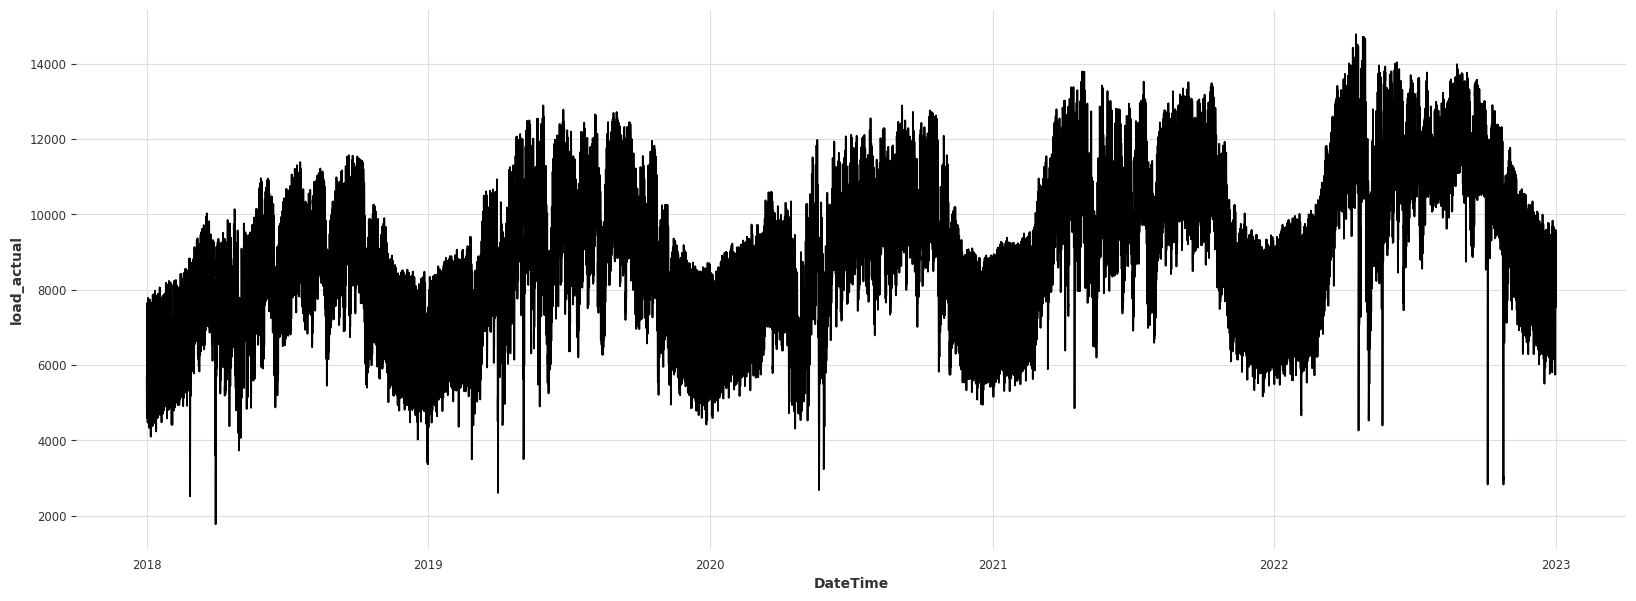

In [16]:
plt.figure(100, figsize=(20, 7))
sns.lineplot(x = "DateTime", y = "load_actual", data = df1, palette="coolwarm");

## Preparing the weather dataframe dfw1

In [17]:
dfw1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394416 entries, 0 to 394415
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   DateTime       394416 non-null  datetime64[ns]
 1   maxtempC       394416 non-null  int64         
 2   mintempC       394416 non-null  int64         
 3   DewPointC      394416 non-null  int64         
 4   FeelsLikeC     394416 non-null  int64         
 5   HeatIndexC     394416 non-null  int64         
 6   cloudcover     394416 non-null  int64         
 7   humidity       394416 non-null  int64         
 8   pressure       394416 non-null  int64         
 9   tempC          394416 non-null  int64         
 10  winddirDegree  394416 non-null  int64         
 11  windspeedKmph  394416 non-null  int64         
 12  Area           394416 non-null  object        
dtypes: datetime64[ns](1), int64(11), object(1)
memory usage: 39.1+ MB


In [18]:
# datetime
dfw1["DateTime"] = pd.to_datetime(dfw1["DateTime"], utc=True, infer_datetime_format=True)
dfw1.set_index("DateTime", inplace=True)


# any non-numeric types?
print("non-numeric columns:",list(dfw1.dtypes[dfw1.dtypes == "object"].index))


# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")  
gaps(dfw1) 


dfw1.describe()

non-numeric columns: ['Area']
no missing values



maxtempC   mintempC  DewPointC  FeelsLikeC  HeatIndexC  cloudcover  \
count 394,416.00 394,416.00 394,416.00  394,416.00  394,416.00  394,416.00   
mean       32.20      23.22      19.35       30.26       30.34       32.20   
std         3.91       4.02       6.36        6.52        6.42       30.68   
min        16.00       9.00      -6.00        9.00        9.00        0.00   
25%        30.00      20.00      14.00       26.00       26.00        4.00   
50%        32.00      24.00      22.00       30.00       30.00       22.00   
75%        34.00      26.00      25.00       35.00       35.00       58.00   
max        48.00      32.00      30.00       55.00       55.00      100.00   

        humidity   pressure      tempC  winddirDegree  windspeedKmph  
count 394,416.00 394,416.00 394,416.00     394,416.00     394,416.00  
mean       65.90   1,008.05      27.25         176.37          10.44  
std        20.07       5.41       4.75          88.51           5.97  
min         4.00     983.00       9.00           0.00           0.00  
25%        51.00   1,004.00      24.00         115.00           6.00  
50%        69.00   1,009.00      27.00         168.00           9.00  
75%        83.00   1,012.00      30.00         232.00          14.00  
max        99.00   1,022.00      48.00         360.00          98.00

In [19]:
# convert int and float64 columns to float32
intcols = list(dfw1.dtypes[dfw1.dtypes == np.int64].index)
dfw1[intcols] = dfw1[intcols].applymap(np.float32)

f64cols = list(dfw1.dtypes[dfw1.dtypes == np.float64].index)
dfw1[f64cols] = dfw1[f64cols].applymap(np.float32)

f32cols = list(dfw1.dtypes[dfw1.dtypes == np.float32].index)
dfw1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 394416 entries, 2018-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   maxtempC       394416 non-null  float32
 1   mintempC       394416 non-null  float32
 2   DewPointC      394416 non-null  float32
 3   FeelsLikeC     394416 non-null  float32
 4   HeatIndexC     394416 non-null  float32
 5   cloudcover     394416 non-null  float32
 6   humidity       394416 non-null  float32
 7   pressure       394416 non-null  float32
 8   tempC          394416 non-null  float32
 9   winddirDegree  394416 non-null  float32
 10  windspeedKmph  394416 non-null  float32
 11  Area           394416 non-null  object 
dtypes: float32(11), object(1)
memory usage: 22.6+ MB


In [20]:
dfw1["pressure"].nsmallest(10)

DateTime
2022-10-30 03:00:00+00:00   983.00
2022-10-30 04:00:00+00:00   983.00
2022-10-30 05:00:00+00:00   984.00
2020-05-20 18:00:00+00:00   984.00
2022-10-30 06:00:00+00:00   985.00
2020-05-20 17:00:00+00:00   985.00
2020-05-20 19:00:00+00:00   985.00
2022-10-30 02:00:00+00:00   986.00
2020-05-20 20:00:00+00:00   986.00
2020-05-20 21:00:00+00:00   986.00
Name: pressure, dtype: float32

In [21]:
#investigate the outliers in the pressure column
dfw1["pressure"].nlargest(10)

DateTime
2020-01-02 09:00:00+00:00   1,022.00
2020-01-02 10:00:00+00:00   1,022.00
2019-01-04 09:00:00+00:00   1,022.00
2020-01-02 08:00:00+00:00   1,022.00
2020-01-02 09:00:00+00:00   1,022.00
2020-01-02 10:00:00+00:00   1,022.00
2020-02-09 09:00:00+00:00   1,022.00
2021-12-31 09:00:00+00:00   1,022.00
2020-01-02 09:00:00+00:00   1,022.00
2019-01-03 09:00:00+00:00   1,021.00
Name: pressure, dtype: float32

In [22]:
#investigate the outliers in the wind_speed column
dfw1["windspeedKmph"].nlargest(10)

DateTime
2020-05-20 21:00:00+00:00   98.00
2020-05-20 20:00:00+00:00   91.00
2020-05-20 22:00:00+00:00   86.00
2020-05-20 19:00:00+00:00   85.00
2020-05-20 18:00:00+00:00   78.00
2020-05-20 23:00:00+00:00   74.00
2019-11-10 03:00:00+00:00   72.00
2019-11-10 04:00:00+00:00   69.00
2020-05-20 17:00:00+00:00   67.00
2019-11-10 05:00:00+00:00   66.00
Name: windspeedKmph, dtype: float32

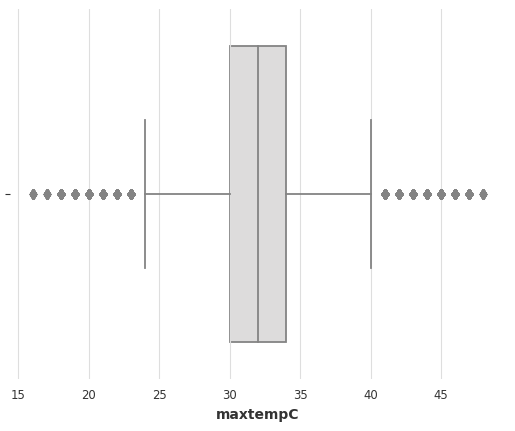

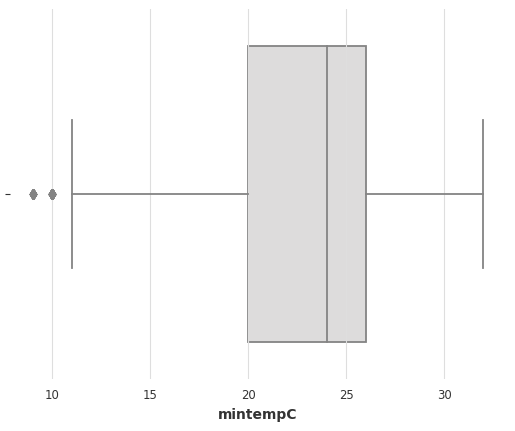

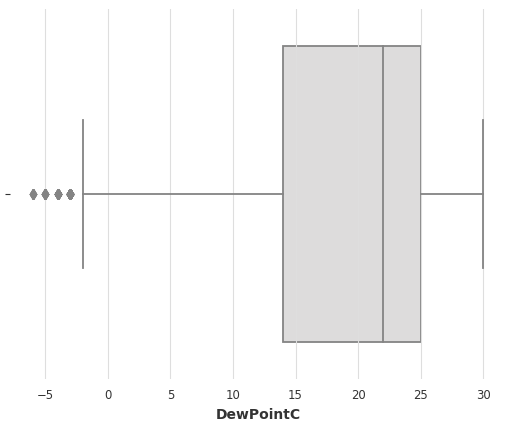

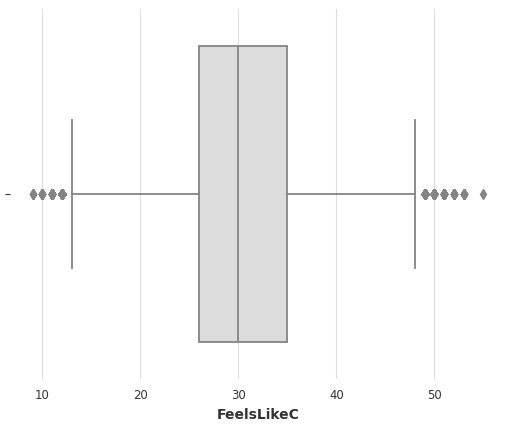

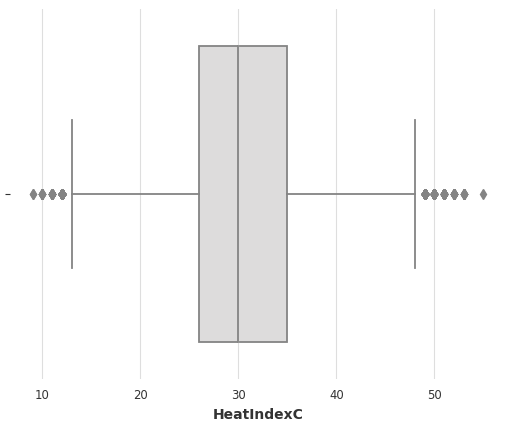

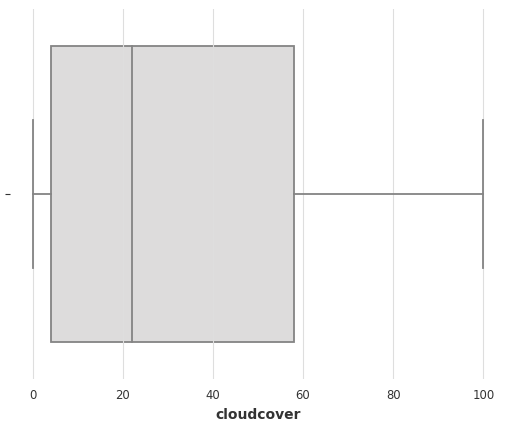

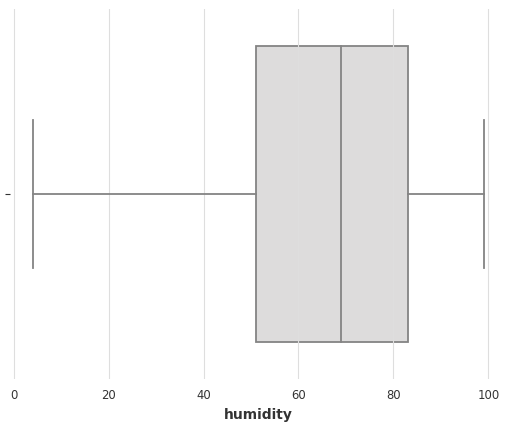

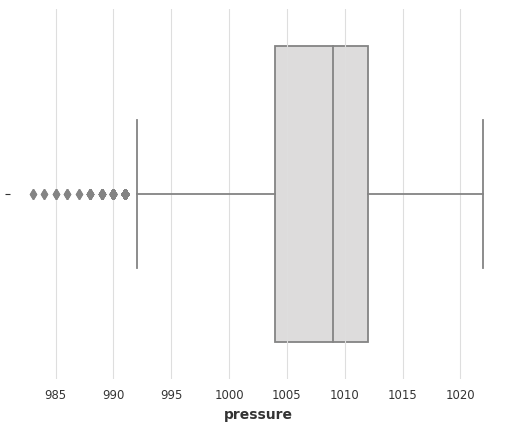

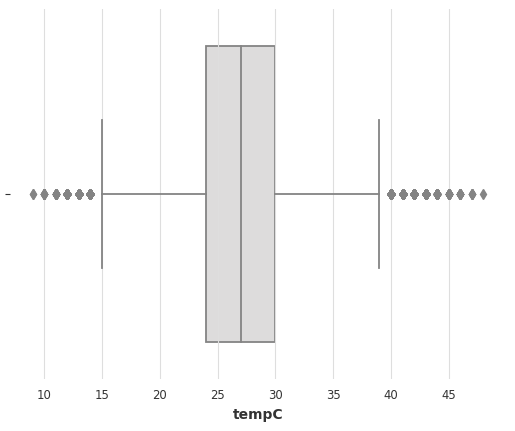

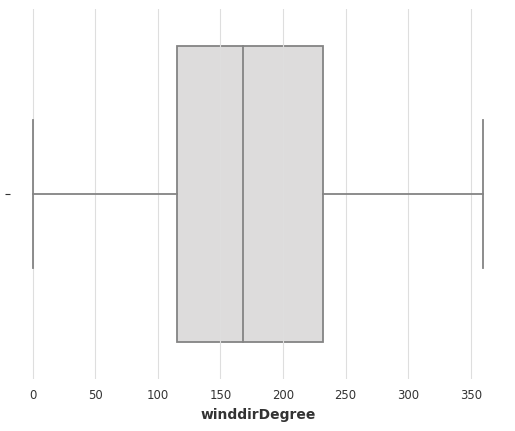

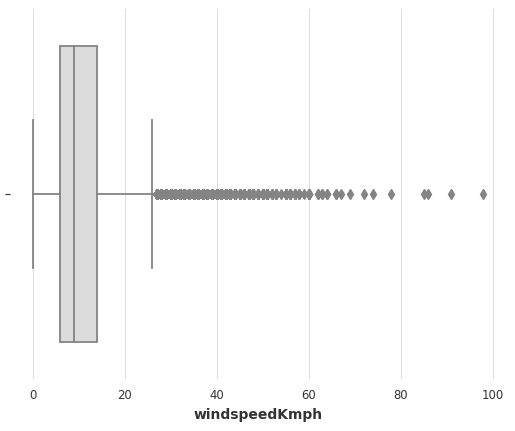

In [23]:
# boxplots
for i, c in enumerate(f32cols):
    sns.boxplot(x=dfw1[c], palette="coolwarm")
    plt.show();

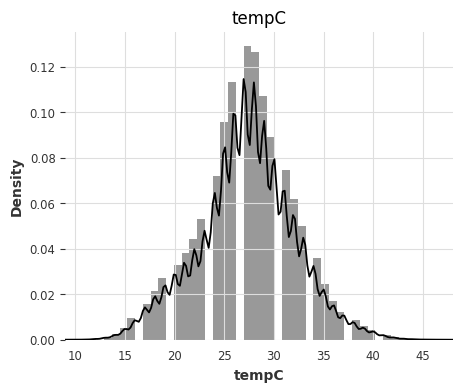

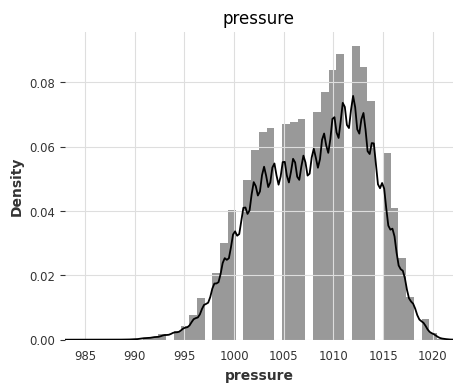

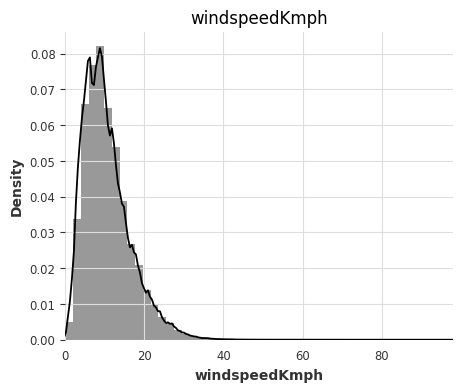

In [24]:
# or use distplot to visualize outliers
fig = plt.figure(figsize=(5, 4)) 
ax = sns.distplot(dfw1["tempC"])
xmin = dfw1["tempC"].min()
xmax = dfw1["tempC"].max()  
ax.set_xlim(xmin, xmax)
ax.set_title("tempC");

fig = plt.figure(figsize=(5, 4))
ax = sns.distplot(dfw1["pressure"])
xmin = dfw1["pressure"].min()
xmax = dfw1["pressure"].max()  
ax.set_xlim(xmin, xmax)
ax.set_title("pressure");

fig = plt.figure(figsize=(5, 4))
ax = sns.distplot(dfw1["windspeedKmph"])
xmin = dfw1["windspeedKmph"].min()
xmax = dfw1["windspeedKmph"].max()  
ax.set_xlim(xmin, xmax)
ax.set_title("windspeedKmph");

In [25]:
# start and end of energy and weather time series 
print("earliest weather time period:", dfw1.index.min())
print("latest weather time period:", dfw1.index.max())

print("earliest energy time period:", df1.index.min())
print("latest energy time period:", df1.index.max())

earliest weather time period: 2018-01-01 00:00:00+00:00
latest weather time period: 2022-12-31 23:00:00+00:00
earliest energy time period: 2018-01-01 00:00:00+00:00
latest energy time period: 2022-12-31 23:00:00+00:00


In [26]:
# cities in weather data
cities = dfw1["Area"].unique()
cities

array(['BARISAL', 'CHITTAGONG', 'COMILLA', 'DHAKA', 'KHULNA',
       'MYMENSINGH', 'RAJSHAHI', 'RANGPUR', 'SYLHET'], dtype=object)

In [27]:
dfw1 = dfw1.reset_index()
# drop duplicate time periods
print("count of duplicates before treatment:",dfw1.duplicated(subset=["DateTime", "Area"], keep="first").sum())

dfw1 = dfw1.drop_duplicates(subset=["DateTime", "Area"], keep="first")
dfw1.reset_index(drop=True, inplace=True)
print("count of duplicates after treatment:",dfw1.duplicated(subset=["DateTime", "Area"], keep="first").sum())

# set datetime index
dfw1["DateTime"] = pd.to_datetime(dfw1["DateTime"], utc=True, infer_datetime_format=True)
dfw1.set_index("DateTime", inplace=True)
# dfw1.drop("DateTime", inplace=True, axis=1)  # You don't need this line as DateTime is already set as index.

print("size of energy dataframe:", df1.shape[0])
dfw1_city = dfw1.groupby("Area").count()
dfw1_city


count of duplicates before treatment: 0
count of duplicates after treatment: 0
size of energy dataframe: 43824


maxtempC  mintempC  DewPointC  FeelsLikeC  HeatIndexC  cloudcover  \
Area                                                                            
BARISAL        43824     43824      43824       43824       43824       43824   
CHITTAGONG     43824     43824      43824       43824       43824       43824   
COMILLA        43824     43824      43824       43824       43824       43824   
DHAKA          43824     43824      43824       43824       43824       43824   
KHULNA         43824     43824      43824       43824       43824       43824   
MYMENSINGH     43824     43824      43824       43824       43824       43824   
RAJSHAHI       43824     43824      43824       43824       43824       43824   
RANGPUR        43824     43824      43824       43824       43824       43824   
SYLHET         43824     43824      43824       43824       43824       43824   

            humidity  pressure  tempC  winddirDegree  windspeedKmph  
Area                                                                 
BARISAL        43824     43824  43824          43824          43824  
CHITTAGONG     43824     43824  43824          43824          43824  
COMILLA        43824     43824  43824          43824          43824  
DHAKA          43824     43824  43824          43824          43824  
KHULNA         43824     43824  43824          43824          43824  
MYMENSINGH     43824     43824  43824          43824          43824  
RAJSHAHI       43824     43824  43824          43824          43824  
RANGPUR        43824     43824  43824          43824          43824  
SYLHET         43824     43824  43824          43824          43824

In [28]:
# count of weather observations by city
print("size of energy dataframe:", df1.shape[0])

dfw1["Area"] = dfw1["Area"].replace("BARISAL", "Barisal")
dfw1["Area"] = dfw1["Area"].replace("CHITTAGONG", "Chittagong")
dfw1["Area"] = dfw1["Area"].replace("COMILLA", "Comilla")
dfw1["Area"] = dfw1["Area"].replace("DHAKA", "Dhaka")
dfw1["Area"] = dfw1["Area"].replace("KHULNA", "Khulna")
dfw1["Area"] = dfw1["Area"].replace("MYMENSINGH", "Mymensingh")
dfw1["Area"] = dfw1["Area"].replace("RAJSHAHI", "Rajshahi")
dfw1["Area"] = dfw1["Area"].replace("RANGPUR", "Rangpur")
dfw1["Area"] = dfw1["Area"].replace("SYLHET", "Sylhet")

dfw1_city = dfw1.groupby("Area")
print("size of city groups in weather dataframe:")
dfw1_city.count()

size of energy dataframe: 43824
size of city groups in weather dataframe:


maxtempC  mintempC  DewPointC  FeelsLikeC  HeatIndexC  cloudcover  \
Area                                                                            
Barisal        43824     43824      43824       43824       43824       43824   
Chittagong     43824     43824      43824       43824       43824       43824   
Comilla        43824     43824      43824       43824       43824       43824   
Dhaka          43824     43824      43824       43824       43824       43824   
Khulna         43824     43824      43824       43824       43824       43824   
Mymensingh     43824     43824      43824       43824       43824       43824   
Rajshahi       43824     43824      43824       43824       43824       43824   
Rangpur        43824     43824      43824       43824       43824       43824   
Sylhet         43824     43824      43824       43824       43824       43824   

            humidity  pressure  tempC  winddirDegree  windspeedKmph  
Area                                                                 
Barisal        43824     43824  43824          43824          43824  
Chittagong     43824     43824  43824          43824          43824  
Comilla        43824     43824  43824          43824          43824  
Dhaka          43824     43824  43824          43824          43824  
Khulna         43824     43824  43824          43824          43824  
Mymensingh     43824     43824  43824          43824          43824  
Rajshahi       43824     43824  43824          43824          43824  
Rangpur        43824     43824  43824          43824          43824  
Sylhet         43824     43824  43824          43824          43824

In [29]:
# separate the cities: a weather dataframe for each of them
dict_city_weather = {city: dfw1[dfw1['Area'] == city] for city in dfw1['Area'].unique()}
dict_city_weather.keys()

dict_keys(['Barisal', 'Chittagong', 'Comilla', 'Dhaka', 'Khulna', 'Mymensingh', 'Rajshahi', 'Rangpur', 'Sylhet'])

In [30]:
# example: Bilbao weather dataframe
dfw_Dhaka = dict_city_weather.get("Dhaka")
print("Dhaka weather:")
dfw_Dhaka.describe()

Dhaka weather:


maxtempC  mintempC  DewPointC  FeelsLikeC  HeatIndexC  cloudcover  \
count 43,824.00 43,824.00  43,824.00   43,824.00   43,824.00   43,824.00   
mean      33.14     24.16      18.95       31.34       31.41       31.79   
std        3.77      3.80       6.41        6.42        6.32       30.67   
min       20.00     11.00      -1.00       11.00       13.00        0.00   
25%       31.00     21.00      13.00       27.00       27.00        4.00   
50%       33.00     25.00      22.00       32.00       32.00       22.00   
75%       35.00     27.00      25.00       36.00       36.00       58.00   
max       46.00     31.00      28.00       53.00       53.00      100.00   

       humidity  pressure     tempC  winddirDegree  windspeedKmph  
count 43,824.00 43,824.00 43,824.00      43,824.00      43,824.00  
mean      60.63  1,007.29     28.26         194.53          11.77  
std       19.20      5.49      4.62          87.88           6.01  
min        8.00    988.00     11.00           0.00           0.00  
25%       46.00  1,003.00     26.00         143.00           8.00  
50%       62.00  1,007.00     28.00         179.00          10.00  
75%       77.00  1,012.00     31.00         261.00          15.00  
max       99.00  1,021.00     46.00         360.00          63.00

In [31]:
dfw_Dhaka.iloc[[0,-1]]

maxtempC  mintempC  DewPointC  FeelsLikeC  \
DateTime                                                               
2018-01-01 00:00:00+00:00     30.00     22.00      13.00       25.00   
2022-12-31 23:00:00+00:00     29.00     16.00       7.00       19.00   

                           HeatIndexC  cloudcover  humidity  pressure  tempC  \
DateTime                                                                       
2018-01-01 00:00:00+00:00       25.00        5.00     55.00  1,012.00  23.00   
2022-12-31 23:00:00+00:00       19.00        1.00     46.00  1,017.00  19.00   

                           winddirDegree  windspeedKmph   Area  
DateTime                                                        
2018-01-01 00:00:00+00:00         273.00           2.00  Dhaka  
2022-12-31 23:00:00+00:00          22.00           8.00  Dhaka

In [32]:
# merge the energy and weather dataframes
df2 = df1.copy()
for city, df in dict_city_weather.items():
    city_name = str(city) + "_"
    df = df.add_suffix("_{}".format(city))
    df2 = pd.concat([df2, df], axis=1)
    if "city_name_" + city in df2.columns:
        df2.drop("city_name_" + city, inplace=True, axis=1)
print(df2.info())
df2.iloc[[0, -1]]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2018-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Columns: 121 entries, gen_tripura to Area_Sylhet
dtypes: float32(112), object(9)
memory usage: 22.1+ MB
None


gen_tripura  gen_east_grid  gen_west_grid  \
DateTime                                                               
2018-01-01 00:00:00+00:00        90.00       4,328.00       1,345.00   
2022-12-31 23:00:00+00:00       100.00       5,016.00       3,093.00   

                           load_actual  gen_gas_pub  gen_HVDC  gen_gas_pri  \
DateTime                                                                     
2018-01-01 00:00:00+00:00     5,673.00     3,015.00    460.00     1,715.00   
2022-12-31 23:00:00+00:00     8,109.00     3,164.00    919.00     1,589.00   

                           gen_oil_pri  gen_coal  gen_hydro  ...  \
DateTime                                                     ...   
2018-01-01 00:00:00+00:00       292.00    169.00      79.00  ...   
2022-12-31 23:00:00+00:00     1,375.00    888.00      46.00  ...   

                           DewPointC_Sylhet  FeelsLikeC_Sylhet  \
DateTime                                                         
2018-01-01 00:00:00+00:00             15.00              19.00   
2022-12-31 23:00:00+00:00              6.00              14.00   

                           HeatIndexC_Sylhet  cloudcover_Sylhet  \
DateTime                                                          
2018-01-01 00:00:00+00:00              19.00              11.00   
2022-12-31 23:00:00+00:00              14.00               2.00   

                           humidity_Sylhet  pressure_Sylhet  tempC_Sylhet  \
DateTime                                                                    
2018-01-01 00:00:00+00:00            80.00         1,013.00         19.00   
2022-12-31 23:00:00+00:00            59.00         1,018.00         14.00   

                           winddirDegree_Sylhet  windspeedKmph_Sylhet  \
DateTime                                                                
2018-01-01 00:00:00+00:00                101.00                  2.00   
2022-12-31 23:00:00+00:00                102.00                  4.00   

                           Area_Sylhet  
DateTime                                
2018-01-01 00:00:00+00:00       Sylhet  
2022-12-31 23:00:00+00:00       Sylhet  

[2 rows x 121 columns]

In [33]:
# any null values?
print("any missing values?", df2.isnull().values.any())

# any ducplicate time periods?
print("count of duplicates:", df2.duplicated(keep="first").sum())

any missing values? False
count of duplicates: 0


# Exploration of Combined Dataframe

In [34]:
# limit the dataframe's date range
df2 = df2[df2.index >= "2022-01-01 00:00:00+00:00"]
df2.iloc[[0,-1]]

gen_tripura  gen_east_grid  gen_west_grid  \
DateTime                                                               
2022-01-01 00:00:00+00:00        65.00       4,562.00       2,201.00   
2022-12-31 23:00:00+00:00       100.00       5,016.00       3,093.00   

                           load_actual  gen_gas_pub  gen_HVDC  gen_gas_pri  \
DateTime                                                                     
2022-01-01 00:00:00+00:00     6,763.00     2,575.00    448.00     1,383.00   
2022-12-31 23:00:00+00:00     8,109.00     3,164.00    919.00     1,589.00   

                           gen_oil_pri  gen_coal  gen_hydro  ...  \
DateTime                                                     ...   
2022-01-01 00:00:00+00:00     1,639.00    569.00      80.00  ...   
2022-12-31 23:00:00+00:00     1,375.00    888.00      46.00  ...   

                           DewPointC_Sylhet  FeelsLikeC_Sylhet  \
DateTime                                                         
2022-01-01 00:00:00+00:00              9.00              15.00   
2022-12-31 23:00:00+00:00              6.00              14.00   

                           HeatIndexC_Sylhet  cloudcover_Sylhet  \
DateTime                                                          
2022-01-01 00:00:00+00:00              15.00               1.00   
2022-12-31 23:00:00+00:00              14.00               2.00   

                           humidity_Sylhet  pressure_Sylhet  tempC_Sylhet  \
DateTime                                                                    
2022-01-01 00:00:00+00:00            67.00         1,018.00         15.00   
2022-12-31 23:00:00+00:00            59.00         1,018.00         14.00   

                           winddirDegree_Sylhet  windspeedKmph_Sylhet  \
DateTime                                                                
2022-01-01 00:00:00+00:00                 84.00                  2.00   
2022-12-31 23:00:00+00:00                102.00                  4.00   

                           Area_Sylhet  
DateTime                                
2022-01-01 00:00:00+00:00       Sylhet  
2022-12-31 23:00:00+00:00       Sylhet  

[2 rows x 121 columns]

In [35]:
# check correlations of features with price
df_corr = df2.corr(method="pearson")
print(df_corr.shape)
print("correlation with load:")
df_corrP = pd.DataFrame(df_corr["load_actual"].sort_values(ascending=False))
df_corrP

(112, 112)
correlation with load:


load_actual
load_actual                 1.00
gen_east_grid               0.97
gen_west_grid               0.93
gen_oil_pri                 0.84
gen_oil_pub                 0.78
...                          ...
pressure_Khulna            -0.63
pressure_Dhaka             -0.64
pressure_Mymensingh        -0.64
pressure_Rangpur           -0.66
pressure_Rajshahi          -0.66

[112 rows x 1 columns]

In [36]:
# highest absolute correlations with price
pd.options.display.float_format = '{:,.2f}'.format
df_corrH = df_corrP[np.abs(df_corrP["load_actual"]) > 0.40]
df_corrH

load_actual
load_actual                 1.00
gen_east_grid               0.97
gen_west_grid               0.93
gen_oil_pri                 0.84
gen_oil_pub                 0.78
...                          ...
pressure_Khulna            -0.63
pressure_Dhaka             -0.64
pressure_Mymensingh        -0.64
pressure_Rangpur           -0.66
pressure_Rajshahi          -0.66

[75 rows x 1 columns]

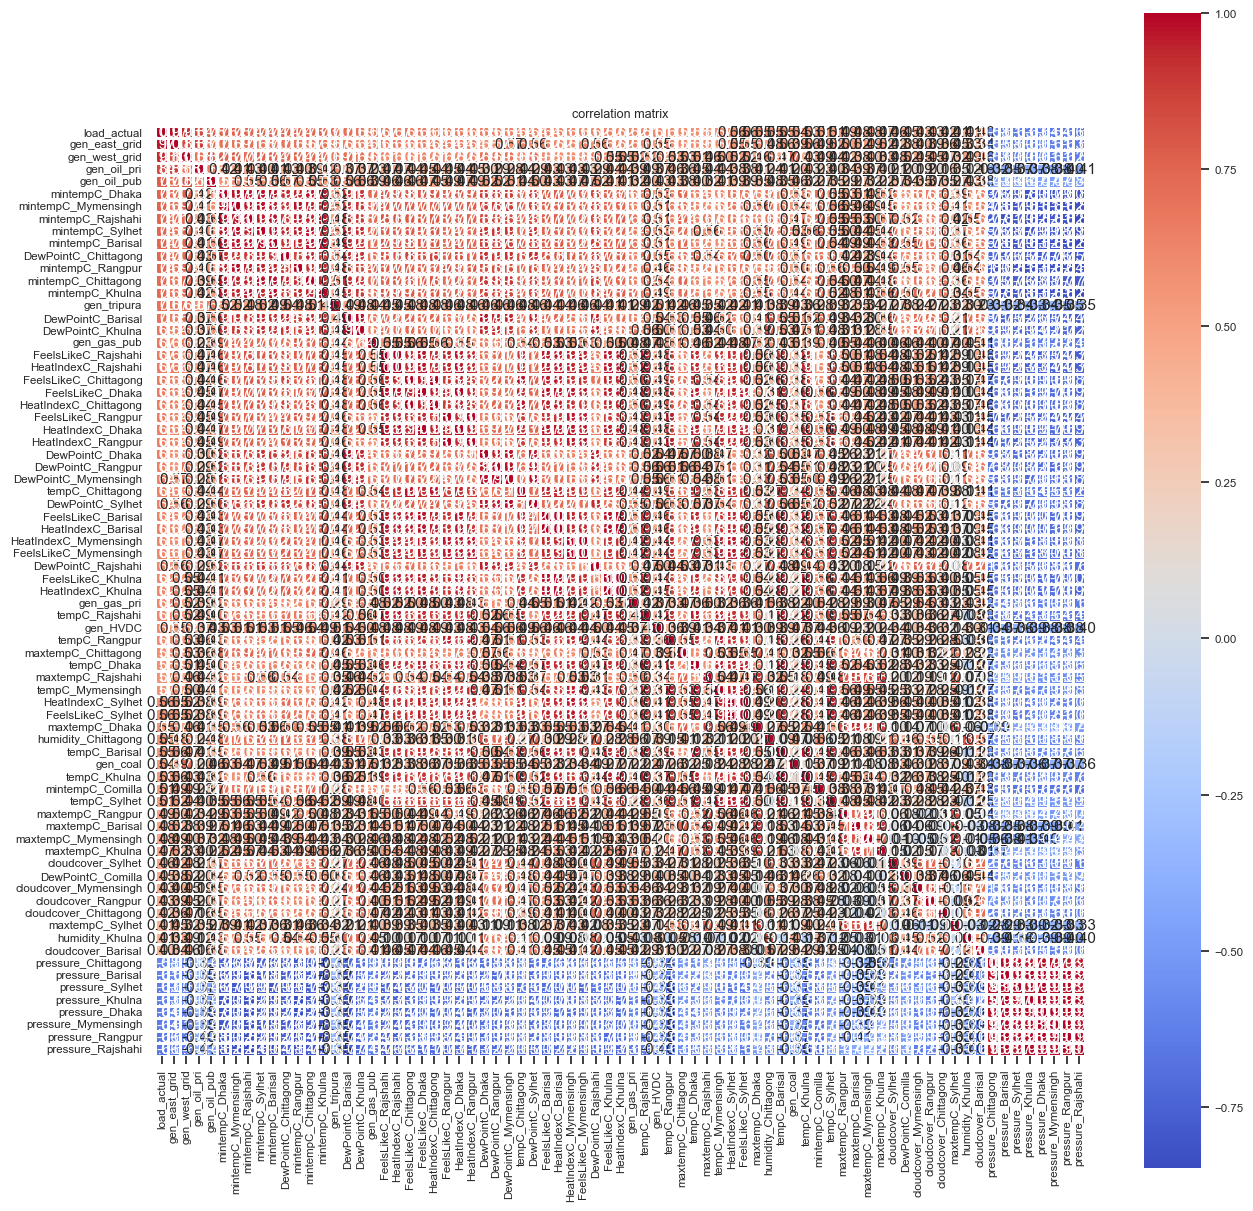

In [37]:
# correlation matrix, limited to highly correlated features
df3 = df2[df_corrH.index]

idx = df3.corr().sort_values("load_actual", ascending=False).index
df3_sorted = df3.loc[:, idx]  # sort dataframe columns by their correlation with Appliances

plt.figure(figsize = (15,15))
sns.set(font_scale=0.75)
ax = sns.heatmap(df3_sorted.corr().round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap="coolwarm", 
            fmt = ".2f", 
            annot_kws = {"size": 11})
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

In [38]:
# limit energy dataframe to columns that have 
# at least a moderate correlation with price
df3 = df2[df_corrH.index]
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Data columns (total 75 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   load_actual            8760 non-null   float32
 1   gen_east_grid          8760 non-null   float32
 2   gen_west_grid          8760 non-null   float32
 3   gen_oil_pri            8760 non-null   float32
 4   gen_oil_pub            8760 non-null   float32
 5   mintempC_Dhaka         8760 non-null   float32
 6   mintempC_Mymensingh    8760 non-null   float32
 7   mintempC_Rajshahi      8760 non-null   float32
 8   mintempC_Sylhet        8760 non-null   float32
 9   mintempC_Barisal       8760 non-null   float32
 10  DewPointC_Chittagong   8760 non-null   float32
 11  mintempC_Rangpur       8760 non-null   float32
 12  mintempC_Chittagong    8760 non-null   float32
 13  mintempC_Khulna        8760 non-null   float32
 14  gen_trip

In [39]:
# additional datetime columns: feature engineering
df3["month"] = df3.index.month

df3["wday"] = df3.index.dayofweek
dict_days = {0:"1_Mon", 1:"2_Tue", 2:"3_Wed", 3:"4_Thu", 4:"5_Fri", 5:"6_Sat", 6:"7_Sun"}
df3["weekday"] = df3["wday"].apply(lambda x: dict_days[x])

df3["hour"] = df3.index.hour

df3 = df3.astype({"hour":float, "wday":float, "month": float})

df3.iloc[[0, -1]]

load_actual  gen_east_grid  gen_west_grid  \
DateTime                                                               
2022-01-01 00:00:00+00:00     6,763.00       4,562.00       2,201.00   
2022-12-31 23:00:00+00:00     8,109.00       5,016.00       3,093.00   

                           gen_oil_pri  gen_oil_pub  mintempC_Dhaka  \
DateTime                                                              
2022-01-01 00:00:00+00:00     1,639.00         4.00           16.00   
2022-12-31 23:00:00+00:00     1,375.00        28.00           16.00   

                           mintempC_Mymensingh  mintempC_Rajshahi  \
DateTime                                                            
2022-01-01 00:00:00+00:00                15.00              15.00   
2022-12-31 23:00:00+00:00                13.00              15.00   

                           mintempC_Sylhet  mintempC_Barisal  ...  \
DateTime                                                      ...   
2022-01-01 00:00:00+00:00            13.00             16.00  ...   
2022-12-31 23:00:00+00:00            11.00             16.00  ...   

                           pressure_Sylhet  pressure_Khulna  pressure_Dhaka  \
DateTime                                                                      
2022-01-01 00:00:00+00:00         1,018.00         1,019.00        1,018.00   
2022-12-31 23:00:00+00:00         1,018.00         1,017.00        1,017.00   

                           pressure_Mymensingh  pressure_Rangpur  \
DateTime                                                           
2022-01-01 00:00:00+00:00             1,018.00          1,019.00   
2022-12-31 23:00:00+00:00             1,018.00          1,018.00   

                           pressure_Rajshahi  month  wday  weekday  hour  
DateTime                                                                  
2022-01-01 00:00:00+00:00           1,019.00   1.00  5.00    6_Sat  0.00  
2022-12-31 23:00:00+00:00           1,017.00  12.00  5.00    6_Sat 23.00  

[2 rows x 79 columns]

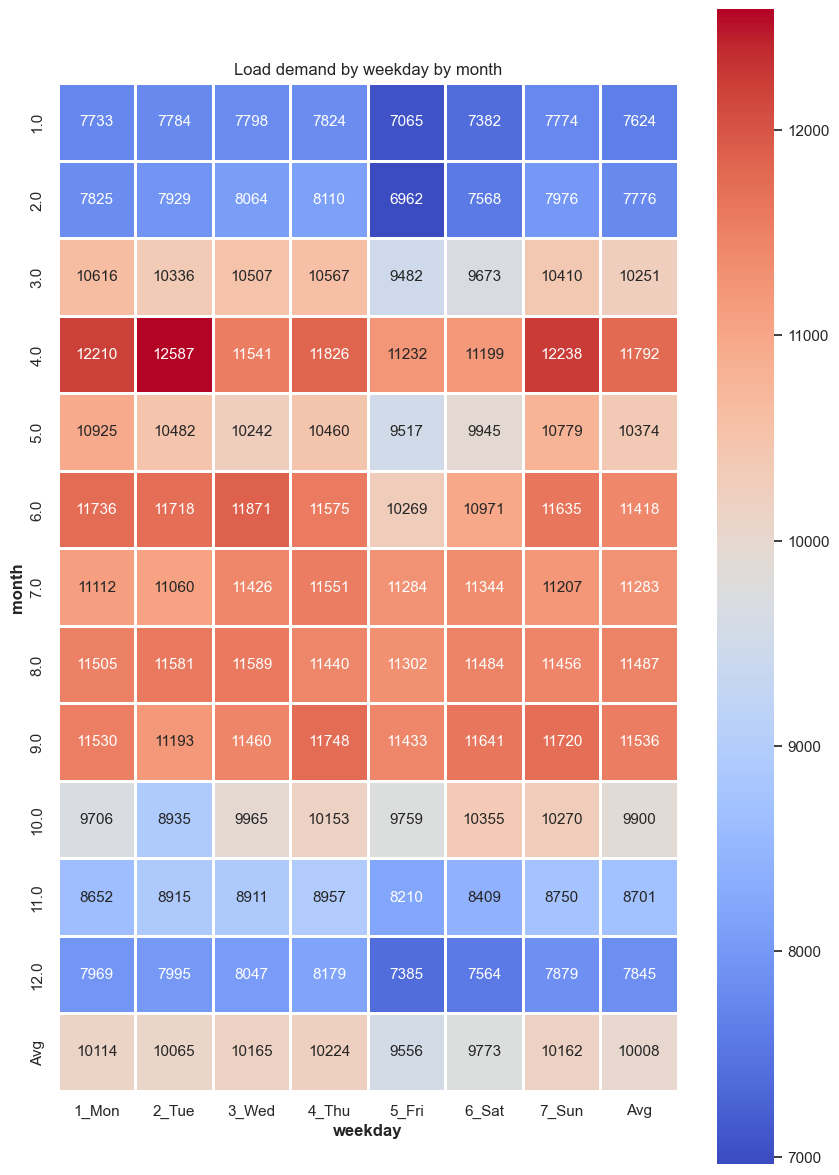

In [40]:
# pivot table: weekdays in months
piv = pd.pivot_table(   df3, 
                        values="load_actual", 
                        index="month", 
                        columns="weekday", 
                        aggfunc="mean", 
                        margins=True, margins_name="Avg", 
                        fill_value=0)
pd.options.display.float_format = '{:,.0f}'.format

plt.figure(figsize = (10,15))
sns.set(font_scale=1)
sns.heatmap(piv.round(0), annot=True, square = True, \
            linewidths=.75, cmap="coolwarm", fmt = ".0f", annot_kws = {"size": 11})
plt.title("Load demand by weekday by month")
plt.show()

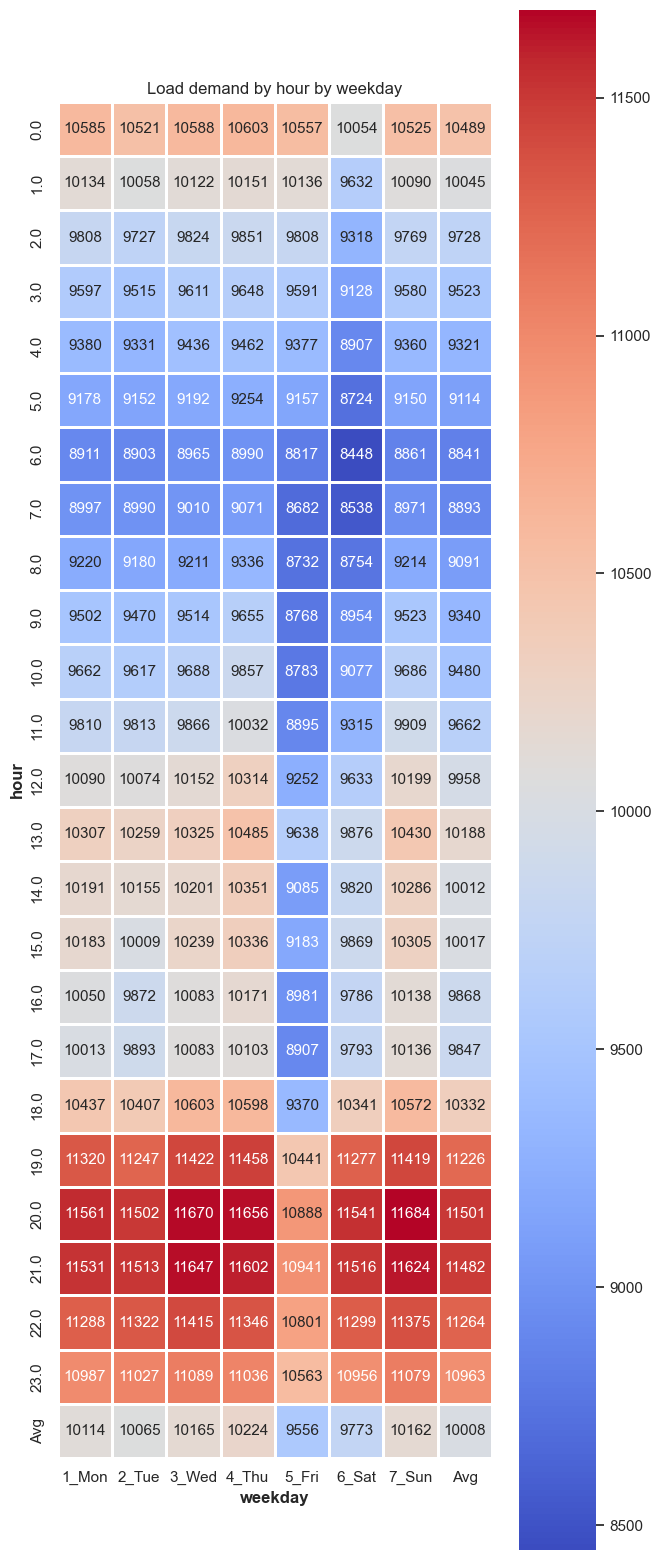

In [41]:
# pivot table: hours in weekdays
piv = pd.pivot_table(   df3, 
                        values="load_actual", 
                        index="hour", 
                        columns="weekday", 
                        aggfunc="mean", 
                        margins=True, margins_name="Avg", 
                        fill_value=0)
pd.options.display.float_format = '{:,.0f}'.format

plt.figure(figsize = (7,20))
sns.set(font_scale=1)
sns.heatmap(piv.round(0), annot=True, square = True, \
            linewidths=.75, cmap="coolwarm", fmt = ".0f", annot_kws = {"size": 11})
plt.title("Load demand by hour by weekday")
plt.show()

In [42]:
# dataframe with price and features only
df4 = df3.copy()
df4.drop(["weekday", "month", "wday", "hour"], inplace=True, axis=1)

# Time Series Object

In [43]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df4["load_actual"]) 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['load_actual'], dtype='object', name='component')
duration: 364 days 23:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [44]:
# create time series object for the feature columns
df_covF = df4.loc[:, df4.columns != "load_actual"]
ts_covF = TimeSeries.from_dataframe(df_covF)

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)


components (columns) of feature time series: Index(['gen_east_grid', 'gen_west_grid', 'gen_oil_pri', 'gen_oil_pub',
       'mintempC_Dhaka', 'mintempC_Mymensingh', 'mintempC_Rajshahi',
       'mintempC_Sylhet', 'mintempC_Barisal', 'DewPointC_Chittagong',
       'mintempC_Rangpur', 'mintempC_Chittagong', 'mintempC_Khulna',
       'gen_tripura', 'DewPointC_Barisal', 'DewPointC_Khulna', 'gen_gas_pub',
       'FeelsLikeC_Rajshahi', 'HeatIndexC_Rajshahi', 'FeelsLikeC_Chittagong',
       'FeelsLikeC_Dhaka', 'HeatIndexC_Chittagong', 'FeelsLikeC_Rangpur',
       'HeatIndexC_Dhaka', 'HeatIndexC_Rangpur', 'DewPointC_Dhaka',
       'DewPointC_Rangpur', 'DewPointC_Mymensingh', 'tempC_Chittagong',
       'DewPointC_Sylhet', 'FeelsLikeC_Barisal', 'HeatIndexC_Barisal',
       'HeatIndexC_Mymensingh', 'FeelsLikeC_Mymensingh', 'DewPointC_Rajshahi',
       'FeelsLikeC_Khulna', 'HeatIndexC_Khulna', 'gen_gas_pri',
       'tempC_Rajshahi', 'gen_HVDC', 'tempC_Rangpur', 'maxtempC_Chittagong',
       'tempC_D

In [45]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(8760, 74, 1)

In [46]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [47]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(SPLIT)
print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled load time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-01-01 00:00:00
training end: 2022-11-25 11:00:00
training duration: 328 days 11:00:00
test start: 2022-11-25 12:00:00
test end: 2022-12-31 23:00:00
test duration: 36 days 11:00:00
first and last row of scaled load time series:


component            load_actual
DateTime                        
2022-01-01 00:00:00         0.33
2022-12-31 23:00:00         0.44

In [48]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(SPLIT)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component            gen_east_grid  gen_west_grid  gen_oil_pri  gen_oil_pub  \
DateTime                                                                      
2022-01-01 00:00:00           0.45           0.29         0.30         0.00   
2022-12-31 23:00:00           0.49           0.49         0.25         0.02   

component            mintempC_Dhaka  mintempC_Mymensingh  mintempC_Rajshahi  \
DateTime                                                                      
2022-01-01 00:00:00            0.19                 0.19               0.17   
2022-12-31 23:00:00            0.19                 0.06               0.17   

component            mintempC_Sylhet  mintempC_Barisal  DewPointC_Chittagong  \
DateTime                                                                       
2022-01-01 00:00:00             0.24              0.19                  0.30   
2022-12-31 23:00:00             0.12              0.19                  0.17   

component            ...  humidity_Khulna  cloudcover_Barisal  \
DateTime             ...                                        
2022-01-01 00:00:00  ...             0.53                0.00   
2022-12-31 23:00:00  ...             0.36                0.03   

component            pressure_Chittagong  pressure_Barisal  pressure_Sylhet  \
DateTime                                                                      
2022-01-01 00:00:00                 0.96              0.93             0.96   
2022-12-31 23:00:00                 0.92              0.89             0.96   

component            pressure_Khulna  pressure_Dhaka  pressure_Mymensingh  \
DateTime                                                                    
2022-01-01 00:00:00             0.96            0.92                 0.92   
2022-12-31 23:00:00             0.89            0.88                 0.92   

component            pressure_Rangpur  pressure_Rajshahi  
DateTime                                                  
2022-01-01 00:00:00              0.96               0.93  
2022-12-31 23:00:00              0.92               0.85  

[2 rows x 74 columns]

In [49]:
# feature engineering - create time covariates: hour, weekday, month, year, country-specific holidays
covT = datetime_attribute_timeseries( ts_P.time_index, attribute="hour", add_length=48 )   # 48 hours beyond end of test set to prepare for out-of-sample forecasting
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="day_of_week")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="month")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="year")  )

covT = covT.astype(np.float32)


# train/test split
covT_train, covT_test = covT.split_after(ts_train.end_time())


# rescale the covariates: fitting on the training set
scalerT = Scaler()
scalerT.fit(covT_train)
covT_ttrain = scalerT.transform(covT_train)
covT_ttest = scalerT.transform(covT_test)
covT_t = scalerT.transform(covT)

covT_t = covT_t.astype(np.float32)


pd.options.display.float_format = '{:.0f}'.format
print("first and last row of unscaled time covariates:")
covT.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled time covariates:


component            hour  day_of_week  month  year
time                                               
2022-01-01 00:00:00     0            5      1  2022
2023-01-02 23:00:00    23            0      1  2023

In [50]:
# combine feature and time covariates along component dimension: axis=1
ts_cov = ts_covF.concatenate( covT.slice_intersect(ts_covF), axis=1 )                      # unscaled F+T
cov_t = covF_t.concatenate( covT_t.slice_intersect(covF_t), axis=1 )                       # scaled F+T
cov_ttrain = covF_ttrain.concatenate( covT_ttrain.slice_intersect(covF_ttrain), axis=1 )   # scaled F+T training set
cov_ttest = covF_ttest.concatenate( covT_ttest.slice_intersect(covF_ttest), axis=1 )       # scaled F+T test set


pd.options.display.float_format = '{:.2f}'.format
print("first and last row of unscaled covariates:")
ts_cov.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled covariates:


component            gen_east_grid  gen_west_grid  gen_oil_pri  gen_oil_pub  \
DateTime                                                                      
2022-01-01 00:00:00        4562.00        2201.00      1639.00         4.00   
2022-12-31 23:00:00        5016.00        3093.00      1375.00        28.00   

component            mintempC_Dhaka  mintempC_Mymensingh  mintempC_Rajshahi  \
DateTime                                                                      
2022-01-01 00:00:00           16.00                15.00              15.00   
2022-12-31 23:00:00           16.00                13.00              15.00   

component            mintempC_Sylhet  mintempC_Barisal  DewPointC_Chittagong  \
DateTime                                                                       
2022-01-01 00:00:00            13.00             16.00                 13.00   
2022-12-31 23:00:00            11.00             16.00                 10.00   

component            ...  pressure_Sylhet  pressure_Khulna  pressure_Dhaka  \
DateTime             ...                                                     
2022-01-01 00:00:00  ...          1018.00          1019.00         1018.00   
2022-12-31 23:00:00  ...          1018.00          1017.00         1017.00   

component            pressure_Mymensingh  pressure_Rangpur  pressure_Rajshahi  \
DateTime                                                                        
2022-01-01 00:00:00              1018.00           1019.00            1019.00   
2022-12-31 23:00:00              1018.00           1018.00            1017.00   

component            hour  day_of_week  month    year  
DateTime                                               
2022-01-01 00:00:00  0.00         5.00   1.00 2022.00  
2022-12-31 23:00:00 23.00         5.00  12.00 2022.00  

[2 rows x 78 columns]

In [51]:
pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled covariates, training + test set:")
cov_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled covariates, training + test set:


component            gen_east_grid  gen_west_grid  gen_oil_pri  gen_oil_pub  \
DateTime                                                                      
2022-01-01 00:00:00           0.45           0.29         0.30         0.00   
2022-12-31 23:00:00           0.49           0.49         0.25         0.02   

component            mintempC_Dhaka  mintempC_Mymensingh  mintempC_Rajshahi  \
DateTime                                                                      
2022-01-01 00:00:00            0.19                 0.19               0.17   
2022-12-31 23:00:00            0.19                 0.06               0.17   

component            mintempC_Sylhet  mintempC_Barisal  DewPointC_Chittagong  \
DateTime                                                                       
2022-01-01 00:00:00             0.24              0.19                  0.30   
2022-12-31 23:00:00             0.12              0.19                  0.17   

component            ...  pressure_Sylhet  pressure_Khulna  pressure_Dhaka  \
DateTime             ...                                                     
2022-01-01 00:00:00  ...             0.96             0.96            0.92   
2022-12-31 23:00:00  ...             0.96             0.89            0.88   

component            pressure_Mymensingh  pressure_Rangpur  pressure_Rajshahi  \
DateTime                                                                        
2022-01-01 00:00:00                 0.92              0.96               0.93   
2022-12-31 23:00:00                 0.92              0.92               0.85   

component            hour  day_of_week  month  year  
DateTime                                             
2022-01-01 00:00:00  0.00         0.83   0.00  0.00  
2022-12-31 23:00:00  1.00         0.83   1.10  0.00  

[2 rows x 78 columns]

In [52]:
print("first and last row of scaled training set covariates:")
cov_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled training set covariates:


component            gen_east_grid  gen_west_grid  gen_oil_pri  gen_oil_pub  \
DateTime                                                                      
2022-01-01 00:00:00           0.45           0.29         0.30         0.00   
2022-11-25 11:00:00           0.49           0.37         0.33         0.13   

component            mintempC_Dhaka  mintempC_Mymensingh  mintempC_Rajshahi  \
DateTime                                                                      
2022-01-01 00:00:00            0.19                 0.19               0.17   
2022-11-25 11:00:00            0.38                 0.31               0.28   

component            mintempC_Sylhet  mintempC_Barisal  DewPointC_Chittagong  \
DateTime                                                                       
2022-01-01 00:00:00             0.24              0.19                  0.30   
2022-11-25 11:00:00             0.35              0.31                  0.52   

component            ...  pressure_Sylhet  pressure_Khulna  pressure_Dhaka  \
DateTime             ...                                                     
2022-01-01 00:00:00  ...             0.96             0.96            0.92   
2022-11-25 11:00:00  ...             0.73             0.75            0.69   

component            pressure_Mymensingh  pressure_Rangpur  pressure_Rajshahi  \
DateTime                                                                        
2022-01-01 00:00:00                 0.92              0.96               0.93   
2022-11-25 11:00:00                 0.69              0.73               0.70   

component            hour  day_of_week  month  year  
DateTime                                             
2022-01-01 00:00:00  0.00         0.83   0.00  0.00  
2022-11-25 11:00:00  0.48         0.67   1.00  0.00  

[2 rows x 78 columns]

In [53]:
print("first and last row of scaled target variable in training set: load:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: load:


component            load_actual
DateTime                        
2022-01-01 00:00:00         0.33
2022-11-25 11:00:00         0.39

In [54]:
print("first and last row of scaled test set covariates:")
cov_ttest.pd_dataframe().iloc[[0,-1]]

first and last row of scaled test set covariates:


component            gen_east_grid  gen_west_grid  gen_oil_pri  gen_oil_pub  \
DateTime                                                                      
2022-11-25 12:00:00           0.53           0.43         0.40         0.14   
2022-12-31 23:00:00           0.49           0.49         0.25         0.02   

component            mintempC_Dhaka  mintempC_Mymensingh  mintempC_Rajshahi  \
DateTime                                                                      
2022-11-25 12:00:00            0.38                 0.31               0.28   
2022-12-31 23:00:00            0.19                 0.06               0.17   

component            mintempC_Sylhet  mintempC_Barisal  DewPointC_Chittagong  \
DateTime                                                                       
2022-11-25 12:00:00             0.35              0.31                  0.57   
2022-12-31 23:00:00             0.12              0.19                  0.17   

component            ...  pressure_Sylhet  pressure_Khulna  pressure_Dhaka  \
DateTime             ...                                                     
2022-11-25 12:00:00  ...             0.69             0.71            0.69   
2022-12-31 23:00:00  ...             0.96             0.89            0.88   

component            pressure_Mymensingh  pressure_Rangpur  pressure_Rajshahi  \
DateTime                                                                        
2022-11-25 12:00:00                 0.69              0.69               0.67   
2022-12-31 23:00:00                 0.92              0.92               0.85   

component            hour  day_of_week  month  year  
DateTime                                             
2022-11-25 12:00:00  0.52         0.67   1.00  0.00  
2022-12-31 23:00:00  1.00         0.83   1.10  0.00  

[2 rows x 78 columns]

In [55]:
print("first and last row of scaled target variable in test set: load:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in test set: load:


component            load_actual
DateTime                        
2022-01-01 00:00:00         0.33
2022-11-25 11:00:00         0.39

# Training: RNN

In [57]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

pl_trainer_kwargs = {"accelerator": "gpu",
      "devices": [0], "callbacks": [my_stopper]}


In [59]:
# Create and train the RNN model
rnn_model = RNNModel(
    model='RNN',
    hidden_dim=FEAT,
    n_rnn_layers=ENCODE,
    input_chunk_length=INLEN,
    output_chunk_length=N_FC,
    n_epochs=EPOCHS,
    nr_epochs_val_period=VALWAIT,
    batch_size=BATCH,
    random_state=RAND,
    dropout=DROPOUT,
    pl_trainer_kwargs=pl_trainer_kwargs
)

rnn_model.fit(ts_ttrain, future_covariates=cov_t, verbose=True)

# Generate RNN predictions
ts_rnn_pred = rnn_model.predict(n=len(ts_ttest), n_jobs=N_JOBS, verbose=True)


Epoch 0: 100%|██████████| 246/246 [00:04<00:00, 59.71it/s, train_loss=0.00556]

RuntimeError: Early stopping conditioned on metric `val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test)

# helper function: get forecast values and insert them in dataframe dfY
def pred(ts_t):
    ts_q = scalerP.inverse_transform(ts_t)
    s = TimeSeries.pd_series(ts_q)
    dfY["Forecast"] = s

    q50_RMSE = rmse(ts_q, ts_test)
    q50_MAPE = mape(ts_q, ts_test) 
    print("RMSE:", f'{q50_RMSE:.2f}')
    print("MAPE:", f'{q50_MAPE:.2f}')
    
# call helper function pred
pred(ts_rnn_pred)

dfY.iloc[np.r_[0:2, -2:0]]

RMSE: 395.53
MAPE: 3.86


Actual  Forecast
DateTime                              
2022-11-25 12:00:00 8,214.00  7,894.13
2022-11-25 13:00:00 8,361.00  8,140.85
2022-12-31 22:00:00 8,697.00  8,757.66
2022-12-31 23:00:00 8,109.00  8,324.13

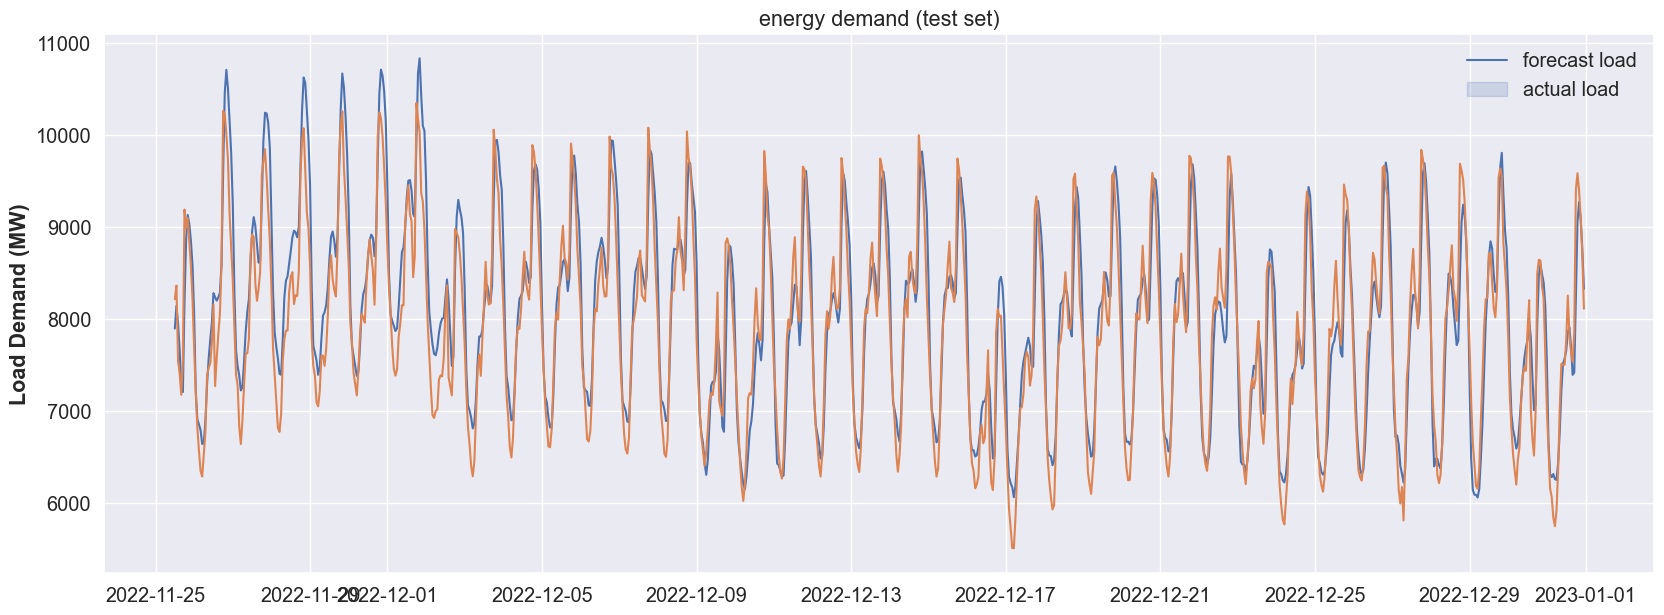

In [ ]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "DateTime", y = "Forecast", data = dfY, palette="coolwarm")
sns.lineplot(x = "DateTime", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast load", "actual load"])
p.set_ylabel("Load Demand (MW)")
p.set_xlabel("")
p.set_title("energy demand (test set)");

In [ ]:
# Create and train the LSTM model
lstm_model = RNNModel(
    model='LSTM',
    hidden_dim=FEAT,
    n_rnn_layers=ENCODE,
    input_chunk_length=INLEN,
    output_chunk_length=N_FC,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    random_state=RAND,
    dropout=DROPOUT
)

lstm_model.fit(ts_ttrain, future_covariates=cov_t, verbose=True)

# Generate LSTM predictions
ts_lstm_pred = lstm_model.predict(n=len(ts_ttest), n_jobs=N_JOBS, verbose=True)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test)

# helper function: get forecast values and insert them in dataframe dfY
def pred(ts_t):
    ts_q = scalerP.inverse_transform(ts_t)
    s = TimeSeries.pd_series(ts_q)
    dfY["Forecast"] = s

    q50_RMSE = rmse(ts_q, ts_test)
    q50_MAPE = mape(ts_q, ts_test) 
    print("RMSE:", f'{q50_RMSE:.2f}')
    print("MAPE:", f'{q50_MAPE:.2f}')
    
# call helper function pred
pred(ts_lstm_pred)

dfY.iloc[np.r_[0:2, -2:0]]

RMSE: 412.36
MAPE: 4.04


Actual  Forecast
DateTime                              
2022-11-25 12:00:00 8,214.00  8,293.74
2022-11-25 13:00:00 8,361.00  8,527.82
2022-12-31 22:00:00 8,697.00  8,095.41
2022-12-31 23:00:00 8,109.00  7,643.15

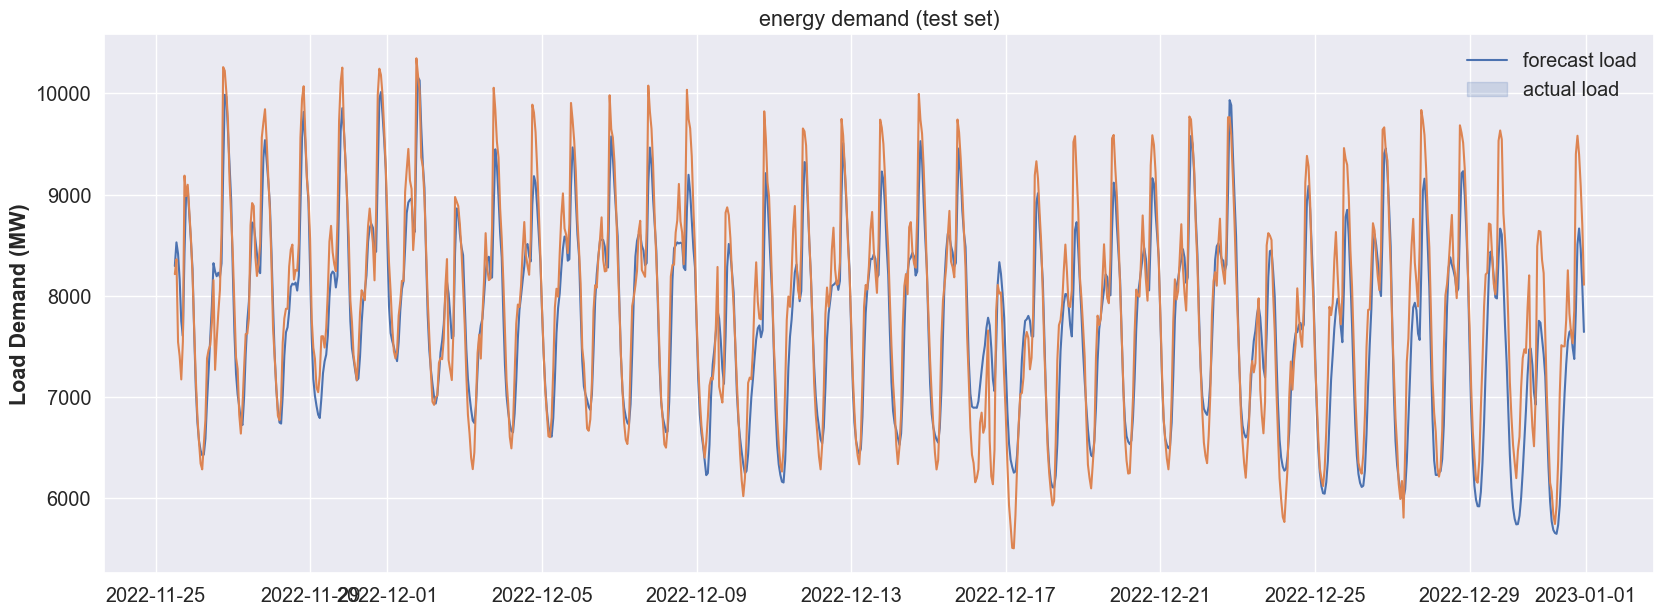

In [ ]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "DateTime", y = "Forecast", data = dfY, palette="coolwarm")
sns.lineplot(x = "DateTime", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast load", "actual load"])
p.set_ylabel("Load Demand (MW)")
p.set_xlabel("")
p.set_title("energy demand (test set)");

# Out-of Sample Forecast

In [ ]:
# choose forecast horizon: k hours beyond end of test set
k = 12   

n_FC = k + len(ts_ttest)   # length of test set + k hours
print("forecast beyond end of training set:", n_FC, 
      "hours beyond", ts_ttrain.end_time())

# last 24 hours of feature covariates available => copy them to future 24 hours:
covF_t_fut = covF_t.concatenate(    other=covF_t.tail(size=24), 
                                    ignore_time_axes=True)
# combine feature and time covariates:
cov_t_fut = covF_t_fut.concatenate(covT_t.slice_intersect(covF_t_fut), axis=1) 
cov_t_fut.pd_dataframe().iloc[[0,-1]]

forecast beyond end of training set: 888 hours beyond 2022-11-25 11:00:00


TypeError: concatenate() got an unexpected keyword argument 'ignore_time_axes'

In [ ]:
# forecast from end of training set until k hours beyond end of test set
ts_tpred = model.predict(   n=n_FC, 
                            past_covariates=cov_t_fut, 
                            num_samples=N_SAMPLES, 
                            verbose=True, 
                            n_jobs=N_JOBS)
print("start:", ts_tpred.start_time(), "; end:",ts_tpred.end_time())


NameError: name 'cov_t_fut' is not defined

In [ ]:
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
#dfY["Actual"] = TimeSeries.pd_series(ts_test)
 
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred, q) for q in QUANTILES]

# move Q50 column to the left, then insert Actual column
col = dfY.pop("Q50")
dfY.insert(0, col.name, col)
dfY.insert(0, "Actual", TimeSeries.pd_series(ts_test))

# show first and last 13 timestamps of forecast
dfY.iloc[np.r_[0:1, -13:0]]  

RMSE: 614.55
MAPE: 5.95


Actual      Q50      Q01      Q10      Q20      Q80  \
DateTime                                                                    
2022-11-25 12:00:00 8,214.00 9,078.44 4,416.15 7,596.86 8,441.79 9,846.00   
2022-12-31 11:00:00 7,501.00 7,919.01 3,346.36 5,022.07 7,095.15 8,403.02   
2022-12-31 12:00:00 7,763.00 8,057.37 3,604.03 6,591.56 7,427.60 8,462.32   
2022-12-31 13:00:00 8,252.00 8,060.70 3,227.66 6,933.24 7,558.55 8,538.54   
2022-12-31 14:00:00 7,824.00 8,079.60 3,225.22 6,600.70 7,452.56 8,599.91   
2022-12-31 15:00:00 7,636.00 8,002.58 3,251.29 6,095.45 7,396.89 8,616.78   
2022-12-31 16:00:00 7,532.00 7,905.70 3,458.41 5,539.73 7,364.00 8,434.42   
2022-12-31 17:00:00 7,855.00 7,930.94 4,136.52 6,478.87 7,445.99 8,607.97   
2022-12-31 18:00:00 9,401.00 8,324.04 4,294.06 7,098.92 7,673.95 8,903.19   
2022-12-31 19:00:00 9,581.00 8,745.70 3,929.74 6,237.54 8,076.25 9,508.32   
2022-12-31 20:00:00 9,396.00 8,863.85 4,989.96 7,276.94 8,055.50 9,326.89   
2022-12-31 21:00:00 9,088.00 8,836.51 4,276.58 6,805.43 8,244.46 9,275.13   
2022-12-31 22:00:00 8,697.00 8,442.57 4,856.18 7,482.80 8,082.66 8,991.74   
2022-12-31 23:00:00 8,109.00 7,902.49 4,447.07 7,034.81 7,564.09 8,747.36   

                          Q90       Q99  
DateTime                                 
2022-11-25 12:00:00 10,005.68 10,710.53  
2022-12-31 11:00:00  9,445.49  9,754.93  
2022-12-31 12:00:00  9,419.41  9,784.58  
2022-12-31 13:00:00  9,308.33  9,938.41  
2022-12-31 14:00:00  9,320.07 10,046.08  
2022-12-31 15:00:00  9,740.77 10,109.47  
2022-12-31 16:00:00  9,078.99 10,006.21  
2022-12-31 17:00:00  9,781.33 10,381.64  
2022-12-31 18:00:00  9,614.88 10,529.11  
2022-12-31 19:00:00 10,041.20 10,968.10  
2022-12-31 20:00:00 10,082.47 11,008.04  
2022-12-31 21:00:00 10,114.49 11,212.15  
2022-12-31 22:00:00 10,045.68 10,886.57  
2022-12-31 23:00:00  9,432.55 10,581.28

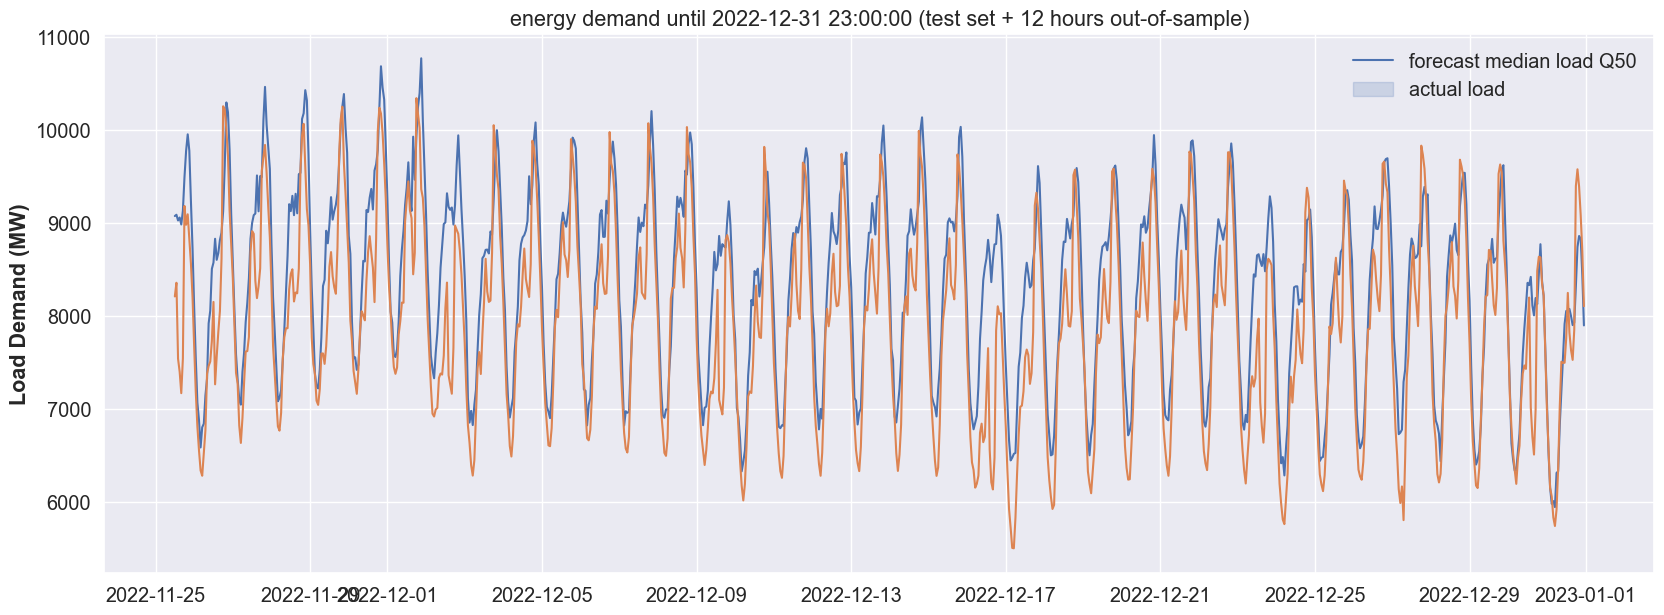

In [ ]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "DateTime", y = "Q50", data = dfY, palette="coolwarm")
sns.lineplot(x = "DateTime", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast median load Q50", "actual load"])
p.set_ylabel("Load Demand (MW)")
p.set_xlabel("")
end = ts_tpred.end_time()
p.set_title("energy demand until {} (test set + {} hours out-of-sample)".format(end, k));